In [6]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import subprocess
from tqdm.notebook import tqdm

## Individual Runtimes of Malloc, work, free

In [7]:
# parameters
n_runs = 10
n_warmup = 10
n_blocks = 100
n_threads_per_block = 1024
n_floats = 20

# workloads
workloads = {
    "sum_reduce": 0,
    "prod_reduce": 1,
    "max_reduce": 2,
    "pair_prod" : 3,
    "sum_all_prod": 4
}

In [19]:
def get_mean_std_individual_workloads(n_blocks, n_threads_per_block, n_floats, n_runs, n_warmup, workload):
    cmd_res = subprocess.run(["./a.out", *[str(x) for x in [n_blocks, n_threads_per_block, n_runs, n_warmup, n_floats, workload]]], capture_output=True, text=True)
    cmd_res.check_returncode()
    measurements = [np.fromstring(x, sep=" ") for x in cmd_res.stdout.split("\n")[:12]]
    
    res = []
    for m in measurements:
        res.append(np.mean(m))
        res.append(np.std(m))

    return res

  0%|          | 0/49 [00:00<?, ?it/s]

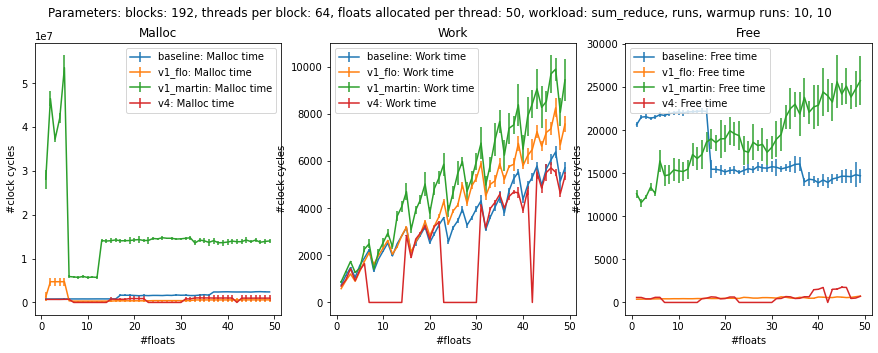

In [20]:
# parameters
n_runs = 10
n_warmup = 10
n_blocks = 192
n_threads_per_block = 64
n_floats = 50
workload = workloads["sum_reduce"]


plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(1, 3)


floats = list(range(1, n_floats))
results = []
for n_floats_ in tqdm(floats):
    results.append(get_mean_std_individual_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats_, n_runs=n_runs, n_warmup=n_warmup, workload=workload))

means_base_malloc_time, stds_base_malloc_time,\
means_base_work_time, stds_base_work_time,\
means_base_free_time, stds_base_free_time,\
means_v1_flo_malloc_time, stds_v1_flo_malloc_time,\
means_v1_flo_work_time, stds_v1_flo_work_time,\
means_v1_flo_free_time, stds_v1_flo_free_time,\
means_v1_martin_malloc_time, stds_v1_martin_malloc_time,\
means_v1_martin_work_time, stds_v1_martin_work_time,\
means_v1_martin_free_time, stds_v1_martin_free_time,\
means_v4_malloc_time, stds_v4_malloc_time,\
means_v4_work_time, stds_v4_work_time,\
means_v4_free_time, stds_v4_free_time\
= zip(*results)


fig.suptitle("Parameters:" \
          + " blocks: " + str(n_blocks)\
          + ", threads per block: " + str(n_threads_per_block)\
          + ", floats allocated per thread: " + str(n_floats)\
          + ", workload: sum_reduce"\
          + ", runs, warmup runs: " + str(n_runs) + ", " + str(n_warmup))

axs[0].set_title("Malloc")
axs[0].errorbar(floats, means_base_malloc_time, stds_base_malloc_time, label="baseline: Malloc time")
axs[0].errorbar(floats, means_v1_flo_malloc_time, stds_v1_flo_malloc_time, label="v1_flo: Malloc time")
axs[0].errorbar(floats, means_v1_martin_malloc_time, stds_v1_martin_malloc_time, label="v1_martin: Malloc time")
axs[0].errorbar(floats, means_v4_malloc_time, stds_v4_malloc_time, label="v4: Malloc time")
axs[0].legend()
axs[0].set_xlabel("#floats")
axs[0].set_ylabel("#clock cycles")

axs[1].set_title("Work")
axs[1].errorbar(floats, means_base_work_time, stds_base_work_time, label="baseline: Work time")
axs[1].errorbar(floats, means_v1_flo_work_time, stds_v1_flo_work_time, label="v1_flo: Work time")
axs[1].errorbar(floats, means_v1_martin_work_time, stds_v1_martin_work_time, label="v1_martin: Work time")
axs[1].errorbar(floats, means_v4_work_time, stds_v4_work_time, label="v4: Work time")
axs[1].legend()
axs[1].set_xlabel("#floats")
axs[1].set_ylabel("#clock cycles")

axs[2].set_title("Free")
axs[2].errorbar(floats, means_base_free_time, stds_base_free_time, label="baseline: Free time")
axs[2].errorbar(floats, means_v1_flo_free_time, stds_v1_flo_free_time, label="v1_flo: Free time")
axs[2].errorbar(floats, means_v1_martin_free_time, stds_v1_martin_free_time, label="v1_martin: Free time")
axs[2].errorbar(floats, means_v4_free_time, stds_v4_free_time, label="v4: Free time")
axs[2].legend()
axs[2].set_xlabel("#floats")
axs[2].set_ylabel("#clock cycles")

plt.show()